# 🚀 Projeto: Transfer Learning


## 1. Conceito Rápido

- Transfer Learning = pegar uma rede pré-treinada em um dataset grande (ex.: ImageNet) e adaptá-la para um novo problema com menos dados.
- Vantagem: não precisa treinar do zero → menos custo computacional + maior acurácia.

## 2. Objetivo

Vamos montar um **notebook de Transfer Learning completo** usando **MobileNetV2**, congelando as primeiras camadas e treinando as últimas com o seu dataset `cats vs dogs`.

## 2. Estrutura do Projeto

    1. Importar bibliotecas
    2. Carregar dataset (Cats vs Dogs)
    3. Pré-processamento das imagens
    4. Carregar modelo pré-treinado
    5. Construir modelo com nova cabeça de classificação
    6. Treinar modelo com Transfer Learning
    7. Avaliar desempenho
    8. Visualizar curva de aprendizado

# Importar Bibliotecas 

In [ ]:
pip install tensorflow matplotlib numpy scipy

     |█▊                              | 32.9 MB 8.4 MB/s eta 0:01:117

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

## Variáveis de Ambiente

In [17]:
IMG_SIZE = (224, 224)  # tamanho para redimensionar todas as imagens
BATCH_SIZE = 32        # número de imagens em cada lote (batch)
DATASET_DIR = './dataset'  # pasta onde estão suas imagens

EPOCHS = 5

#### EPOCHS

- **Época (epoch)** = 1 vez que o modelo vê **todas as imagens do conjunto de treino**.
- Aqui ele vai treinar por **5 épocas** → ou seja, passar 5 vezes pelo dataset inteiro.

#  Carregar dataset 

O link do dataset [https://www.microsoft.com/en-us/download/details.aspx?id=54765](https://www.microsoft.com/en-us/download/details.aspx?id=54765) 
~~~
dataset/
  cat/
    0.jpg
    1.jpg
  dog/
    0.jpg
    1.jpg
~~~ 

## Gerador com augmentação 

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,        # normaliza os pixels (0-255 → 0-1)
    rotation_range=20,     # gira imagens até 20°
    width_shift_range=0.2, # desloca largura até 20%
    height_shift_range=0.2,# desloca altura até 20%
    shear_range=0.2,       # aplica corte (shear)
    zoom_range=0.2,        # aplica zoom
    horizontal_flip=True,  # inverte horizontalmente
    validation_split=0.2   # separa 20% das imagens para validação
)


👉 Isso cria um gerador de imagens que, além de normalizar, aumenta artificialmente os dados para evitar overfitting.
Por exemplo, uma mesma imagem pode aparecer girada, com zoom, deslocada ou espelhada.

## Conjunto de treino:

In [4]:
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,     # redimensiona imagens
    batch_size=BATCH_SIZE,    # usa 32 imagens por lote
    class_mode='binary',      # rótulos binários (0 ou 1)
    subset='training'         # pega os 80% de treino
)


Found 20000 images belonging to 2 classes.


👉 Vai buscar as imagens na pasta ./dataset, criar os lotes de treino e aplicar as transformações definidas.

O class_mode='binary' indica que é classificação binária (ex: gato vs cachorro).

## Conjunto de validação:

In [5]:
val_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'  # pega os 20% de validação
)

Found 4998 images belonging to 2 classes.


👉 Faz a mesma coisa que o train_generator, mas agora gera os lotes de validação (sem eles, você não teria como medir o desempenho durante o treino).

## Carregar MobileNetV2 sem a última camada

In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

2025-09-08 00:19:29.698102: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


- weights='imagenet' → carrega a rede já treinada no banco de dados ImageNet (1.2 milhão de imagens, 1000 classes).

- include_top=False → remove as últimas camadas de classificação originais (as que classificavam as 1000 classes do ImageNet).

- input_shape=(224,224,3) → define que suas imagens de entrada são 224x224 pixels com 3 canais (RGB).

👉 Isso significa que você está aproveitando o conhecimento já aprendido pela MobileNetV2 (detecção de bordas, formas, texturas etc.), mas vai adaptar para o seu problema.

## Congelar camadas da base

In [10]:
base_model.trainable = False

- “Congelar” = não atualizar os pesos da MobileNetV2 durante o treinamento.
- Assim, você usa o modelo pré-treinado como um extrator de características fixo.
- Isso evita overfitting quando seu dataset é pequeno.

## Adicionar camadas finais para o seu problema

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

- `GlobalAveragePooling2D` → reduz o mapa de características em um vetor (faz a média dos valores de cada canal).
    - Isso substitui o `Flatten()`, mas de forma mais eficiente.
- `Dense(128, activation='relu')` → adiciona uma camada totalmente conectada com 128 neurônios.
- `Dense(1, activation='sigmoid')` → saída final:
    - 1 neurônio porque é **classificação binária**.
    - `sigmoid` gera valores entre 0 e 1 → probabilidade de ser classe 1.

## Montar o modelo

In [13]:
model = Model(inputs=base_model.input, outputs=predictions)

- Conecta a entrada da MobileNetV2 com suas novas camadas.
- Agora o modelo é: **MobileNetV2 congelada + suas camadas de classificação**.

## Compilar o modelo

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


- **Otimizador Adam** → bom equilíbrio entre velocidade e estabilidade.
- **Taxa de aprendizado 0.0001** → baixa, porque você não quer destruir os pesos pré-treinados.
- **Loss: binary_crossentropy** → usada para classificação binária.
- **Métrica: accuracy** → porcentagem de acertos.

## Resumo do modelo

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

- Mostra todas as camadas, parâmetros treináveis e não treináveis.
- Você vai ver que os parâmetros da MobileNetV2 estão **não-treináveis** (congelados).

## Treinamento

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

/home/ryoshio/Estudo/Dio/jupyterNotebook/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 31/625 ━━━━━━━━━━━━━━━━━━━━ 3:02 307ms/step - accuracy: 0.6085 - loss: 0.7611

/home/ryoshio/Estudo/Dio/jupyterNotebook/venv/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9109 - loss: 0.2233

/home/ryoshio/Estudo/Dio/jupyterNotebook/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 407ms/step - accuracy: 0.9532 - loss: 0.1240 - val_accuracy: 0.9685 - val_loss: 0.0780
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 252s 404ms/step - accuracy: 0.9721 - loss: 0.0722 - val_accuracy: 0.9704 - val_loss: 0.0769
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 254s 406ms/step - accuracy: 0.9741 - loss: 0.0655 - val_accuracy: 0.9724 - val_loss: 0.0693
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 283s 454ms/step - accuracy: 0.9762 - loss: 0.0642 - val_accuracy: 0.9760 - val_loss: 0.0688
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 281s 449ms/step - accuracy: 0.9765 - loss: 0.0614 - val_accuracy: 0.9764 - val_loss: 0.0679


**Parâmetros:**

- train_generator → é o gerador que entrega lotes de imagens de treino (com augmentação).
- steps_per_epoch
    - Quantos lotes por época.
    - train_generator.samples = total de imagens de treino.
    - Divide pelo BATCH_SIZE para calcular quantos lotes existem.
    - Exemplo: se tem 800 imagens e batch_size=32 → 800/32 = 25 steps por época.
- validation_data=val_generator → usa o gerador de validação para medir desempenho a cada época.

- validation_steps
    - Quantos lotes de validação por época.
    - Calculado do mesmo jeito.

- epochs=EPOCHS → número de vezes que o modelo vai passar por todo o conjunto.


**O objeto history guarda a evolução do treino:**

- history.history['loss'] → perda (loss) no treino.
- history.history['accuracy'] → acurácia no treino.
- history.history['val_loss'] → perda na validação.
- history.history['val_accuracy'] → acurácia na validação.

In [14]:
# Descongelar últimas 50 camadas da base
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Compilar novamente com learning rate menor
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treinar mais algumas épocas
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=5
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 551ms/step - accuracy: 0.9510 - loss: 0.1207 - val_accuracy: 0.9772 - val_loss: 0.0611
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 342s 548ms/step - accuracy: 0.9693 - loss: 0.0799 - val_accuracy: 0.9780 - val_loss: 0.0596
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 343s 549ms/step - accuracy: 0.9738 - loss: 0.0683 - val_accuracy: 0.9754 - val_loss: 0.0532
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 347s 555ms/step - accuracy: 0.9754 - loss: 0.0630 - val_accuracy: 0.9764 - val_loss: 0.0590
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 354s 566ms/step - accuracy: 0.9781 - loss: 0.0563 - val_accuracy: 0.9788 - val_loss: 0.0524


Esse trecho aí é a fase de **fine-tuning** do modelo ✅.

Até agora, você treinou só as **camadas novas** que adicionou em cima da MobileNetV2 (as `Dense`). A MobileNet estava **congelada**, funcionando só como extrator de características fixo.

Agora você vai permitir que **parte da MobileNetV2 também seja ajustada** para o seu dataset.

---

### 🔹 Passo 1 — Descongelar só as últimas 50 camadas

```python
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False
```

* Aqui você libera toda a MobileNet para ser treinável (`trainable = True`).
* Mas logo em seguida, congela **todas as camadas, exceto as últimas 50**.
* Isso significa:

  * As **camadas iniciais** continuam fixas (responsáveis por detectar bordas, texturas simples etc.).
  * Só as **camadas finais da MobileNet** e o seu classificador vão ser atualizados (elas captam padrões mais complexos e específicos).

👉 Esse truque é importante porque:

* Congelar camadas iniciais evita **destruir o aprendizado básico** já feito no ImageNet.
* Descongelar camadas finais permite **ajustar melhor ao seu problema específico**.

---

### 🔹 Passo 2 — Compilar de novo com learning rate menor

```python
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
```

* Agora que algumas camadas pré-treinadas vão ser ajustadas, você usa um **learning rate bem menor** (`1e-5` em vez de `1e-4`).
* Por quê?

  * Se a taxa for alta, você pode “apagar” o conhecimento da MobileNet.
  * Com taxa baixa, você faz um ajuste fino, suave.

---

### 🔹 Passo 3 — Treinar mais algumas épocas

```python
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=5
)
```

* Continua o treino, mas agora com **parte da MobileNetV2 ajustando seus pesos** junto com as camadas que você adicionou.
* O nome disso é **fine-tuning** (ajuste fino).

---

📌 **Resumindo em uma frase:**
Esse código libera as últimas 50 camadas da MobileNetV2 para serem treinadas com uma taxa de aprendizado bem baixa, de forma a refinar o modelo para o seu dataset sem perder o que ele já aprendeu no ImageNet.

---

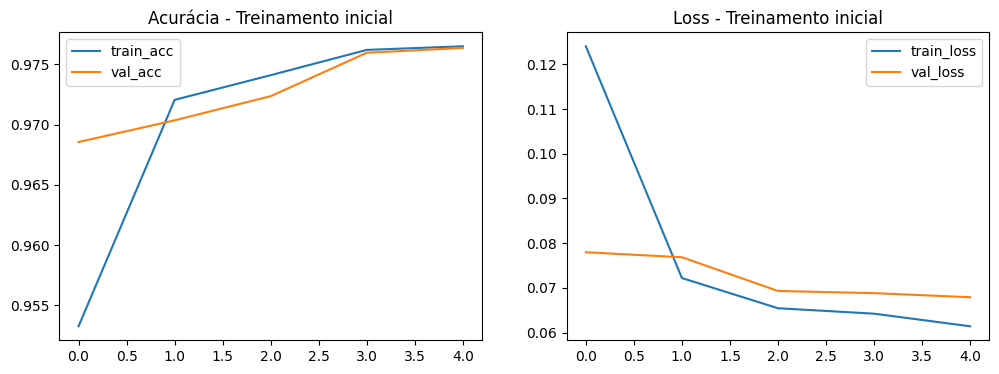

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Acurácia - Treinamento inicial')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss - Treinamento inicial')
plt.show()

In [21]:
def classify_image(model, img_path, img_size=(224, 224)):
    # Carregar e redimensionar a imagem
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalizar igual ao treinamento

    # Fazer previsão
    pred = model.predict(img_array)[0][0]

    # Interpretar resultado
    if pred < 0.5:
        label = 'Gato'
    else:
        label = 'Cachorro'

    # Mostrar imagem com resultado
    plt.imshow(img)
    plt.title(f'Predição: {label} ({pred:.2f})')
    plt.axis('off')
    plt.show()
    
    return label


In [22]:
def classify_image_url(model, img_url, img_size=(224,224)):
    # Baixar a imagem da URL
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    
    # Redimensionar e normalizar
    img_resized = img.resize(img_size)
    img_array = np.array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Previsão
    pred = model.predict(img_array)[0][0]
    label = 'Gato' if pred < 0.5 else 'Cachorro'

    # Mostrar imagem com resultado
    plt.imshow(img)
    plt.title(f'Predição: {label} ({pred:.2f})')
    plt.axis('off')
    plt.show()
    
    return label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


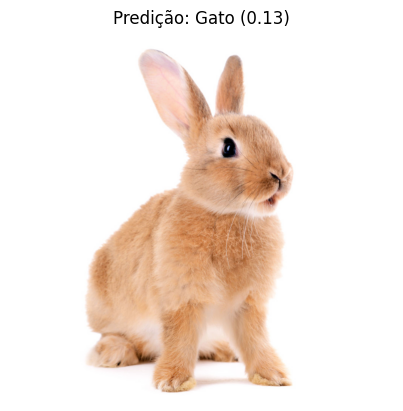

O modelo disse: Gato


In [23]:
img_url = 'https://cobasiblog.blob.core.windows.net/production-ofc/2018/08/coelho-bege-blog-cobasi-1024x986.jpg'
resultado = classify_image_url(model, img_url)
print("O modelo disse:", resultado)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


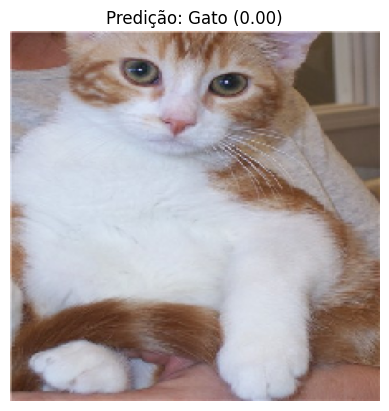

O modelo disse: Gato


In [23]:

img_path = './dataset/Cat/9.jpg'
resultado = classify_image(model, img_path)
print("O modelo disse:", resultado)
